# [MIPT_DL_CAPTCHA] Распознование букв английского алфавита в виде CAPTCHA

# <a id="0">Содержание</a>

- <a href="#1">Описание задачи и данных</a>
- <a href="#2">Загрузка библиотек</a>  
- <a href="#3">Загрузка данных и их рассмотрение</a>  
- <a href="#4">Исследование классов</a>
    - <a href="#41">Распределение классов</a>
    - <a href="#42">Примеры изображений</a>
- <a href="#5">Создание модели</a>  
    - <a href="#51">Подготовка данных</a>  
    - <a href="#52">Разделение и трансформация данных</a>  
    - <a href="#53">Создание арзхитектуры модели</a>   
    - <a href="#54">Обучение модели</a>   
    - <a href="#55">Проверка модели на тестовых данных</a>  
    - <a href="#56">Сохранение предсказаний на тестовых данных<</a>   
- <a href="#6">Выводы</a>

# <a id="1">Описание задачи и данных</a>

**Описание задачи**

В этом соревновании вам предлагается задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях. Примеры:

![Пример](./other/inbox.png)

Данные для обучения содержатся в двух файлах: images.npy и labels.npy. Это формат numpy-массивов.

Ваша задача — обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла `images_sub.npy`, в нем 50 тысяч изображений. Посмотрите на структуру файла `sample_submission.csv` — он не содержит полезных данных, а лишь описывает формат, в котором вы загружаете ваши предсказания на сайт. Создайте из ваших предсказаний такой же файл и загрузите в качестве вашего ответа (сабмита). Вы можете делать до 20 сабмитов в сутки.
Метрика лидерборда — accuracy, то есть доля правильно распознанных изображений.

Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.82.

**Описание данных**

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве `labels` содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

- images.npy - изображения для обучения
- labels.npy - метки для обучения
- sample_submission.csv - формат файла для сабмита
- images_sub.npy - изображения для сабмита

Файлы .npy - это сохраненные numpy-массивы. Их можно загрузить с помощью функции np.load(filename)

# <a id="2">Загрузка библиотек</a>  

In [124]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split, Dataset
from torchvision.transforms import ToPILImage, ToTensor, Compose, Resize, CenterCrop, Normalize
from torchvision import transforms

import timm

from sklearn.metrics import accuracy_score

import warnings

In [125]:
warnings.filterwarnings('ignore')

# <a id="3">Загрузка данных</a>  

Загрузим изначальные данные для рассмотрения

In [126]:
# Загрузим датасеты
images = np.load('data/images.npy')
images_for_pred = np.load('data/images_sub.npy')
labels = np.load('data/labels.npy')

In [127]:
# Проверка форм массивов
print(f'Форма массива изображений: {images.shape}')
print(f'Форма массива меток: {labels.shape}')

Форма массива изображений: (20000, 48, 48, 3)
Форма массива меток: (20000,)


В тренировочном датасете дано 20 тыс. объектов с информацией о рисунках размером 48*48 пикселей. Также имеется отдельные данные с метками `labels`, обозначающими определенную букву английского алфавита

In [128]:
# Проверка форм массивов
print(f'Форма массива изображений для предсказания: {images_for_pred.shape}')

Форма массива изображений для предсказания: (50000, 48, 48, 3)


В тестовом датасете для предсказания в наличии 50 тыс. объектов с информацией о рисунках размером 48*48 пикселей. Структура данных такая же, как в тренировочных данных

In [129]:
# Загрузим данные для примера
sample = pd.read_csv('data/sample_submission.csv')
# Посмотрим первые 5 строк
display(sample.head())
# Посмотрим информацию о датасете
sample.info()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


Итоговый датасет, который необходимо направить на проверку должен состоять из столбwов `Id` с номером строки из тестового датасета и `Category` с предсказанными классами

# <a id="4">Исследование данных</a>  

## <a id="41">Распределение классов</a>

Давайте рассмотрим распределение классов в тренировочном датасете

In [130]:
# Вывод уникальных меток и их количества
unique_labels, counts = np.unique(labels, return_counts=True)
print(f'Уникальные метки: {unique_labels}')
print(f'Количество каждого класса: {counts}')

Уникальные метки: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Количество каждого класса: [ 748  878  710  880  764  677  816  904  440  497  794  512  972  921
  871  759  866  929  739  575  763  739 1013  816  682  735]


In [131]:
# Визуализация распределения классов
def plot_class_distribution(labels):
    """
    Отображает распределение классов в виде гистограммы.

    Аргументы:
    labels -- массив меток размером (N,), где каждая метка - целое число от 0 до 25.

    Возвращает:
    None
    """
    # Преобразуем числовые метки в буквы
    label_names = [chr(label + 65) for label in unique_labels]
    
    # Создаем гистограмму
    plt.figure(figsize=(12, 6))
    plt.bar(label_names, counts, color='skyblue')
    
    # Добавляем подписи и заголовок
    plt.xlabel('Классы букв')
    plt.ylabel('Частота')
    plt.title('Распределение классов букв')
    
    # Показываем гистограмму
    plt.show()

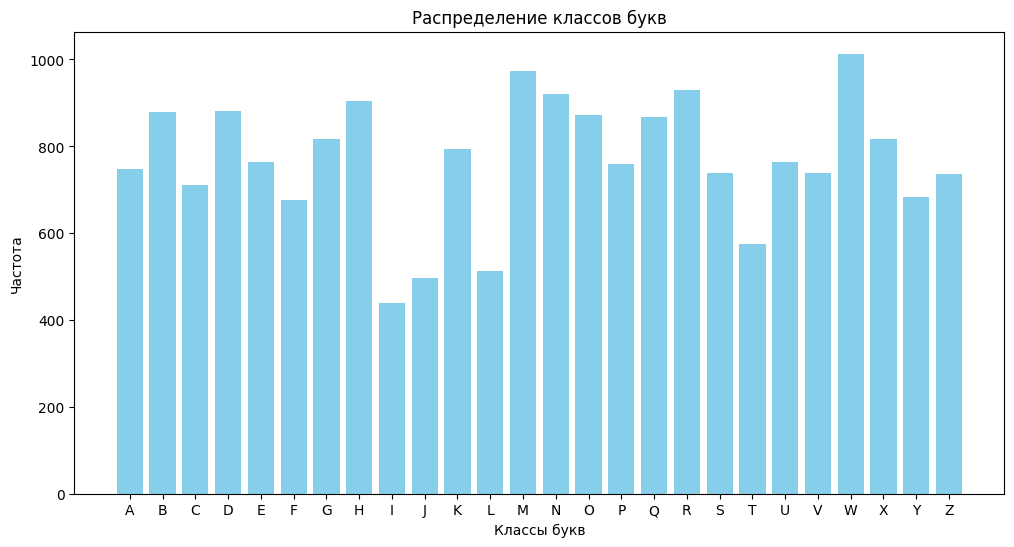

In [132]:
# Вызов функции для визуализации распределения классов
plot_class_distribution(labels)

**Выводы:**
- График показывает, что количество образцов для каждого класса (буквы английского алфавита) неодинаково. Это означает, что данные не сбалансированы.
- Классы, соответствующие буквам B, D, H, M, N, R, W имеют более высокую частоту, в то время как классы, соответствующие буквам I, J, и L, встречаются реже. Это может повлиять на точность модели при распознавании менее часто встречающихся классов.
- Может потребоваться применение техник балансировки классов, таких как взвешивание классов в функции потерь, использование техник аугментации данных для редко встречающихся классов или ресэмплинг данных, чтобы обеспечить более равномерное обучение по всем классам

## <a id="42">Примеры изображений</a>

Рассмотрим несколько примеров изображений из тренировочного датасета. Для этого создадим функцию для формирования изображений

In [133]:
def plot_images(images, labels, num_images=10):
    """
    Отображает заданное количество изображений с метками.

    Аргументы:
    images -- массив изображений размером (N, 48, 48, 3).
    labels -- массив меток размером (N,), где каждая метка - целое число от 0 до 25, соответствующее буквам английского алфавита.
    num_images -- количество изображений для отображения (по умолчанию 10).

    Возвращает:
    None
    """
    # Устанавливаем размер фигуры для визуализации
    plt.figure(figsize=(15, 5))
    
    # Перебираем заданное количество изображений
    for i in range(num_images):
        # Создаем subplot для каждого изображения
        plt.subplot(2, num_images // 2, i + 1)
        
        # Отображаем изображение с индексом i
        plt.imshow(images[i])
        
        # Устанавливаем заголовок для каждого изображения, используя метку, преобразованную в букву
        plt.title(f'Label: {chr(labels[i] + 65)}')
        
        # Отключаем оси для лучшей визуализации
        plt.axis('off')
    
    # Показываем фигуру с изображениями
    plt.show()

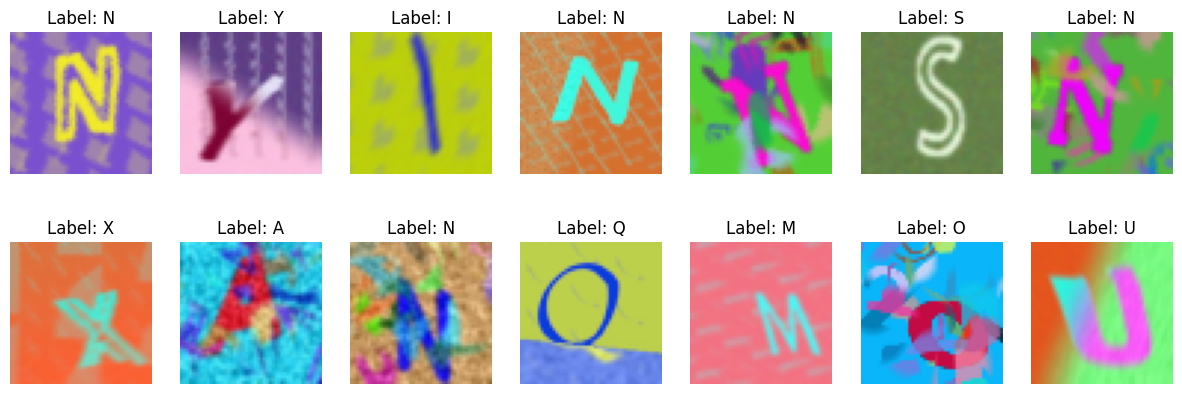

In [134]:
# Вызов функции для визуализации изображений
plot_images(images, labels, num_images=14)

Теперь отобразим изображения из тестовой выборки

In [135]:
def plot_test_images(images, num_images=10):
    """
    Отображает заданное количество тестовых изображений без меток.

    Аргументы:
    images -- массив изображений размером (N, 48, 48, 3).
    num_images -- количество изображений для отображения (по умолчанию 10).

    Возвращает:
    None
    """
    # Устанавливаем размер фигуры для визуализации
    plt.figure(figsize=(15, 5))
    
    # Перебираем заданное количество изображений
    for i in range(num_images):
        # Создаем subplot для каждого изображения
        plt.subplot(2, num_images // 2, i + 1)
        
        # Отображаем изображение с индексом i
        plt.imshow(images[i])
        
        # Устанавливаем заголовок для каждого изображения, указывая его индекс
        plt.title(f'Image {i}')
        
        # Отключаем оси для лучшей визуализации
        plt.axis('off')
    
    # Показываем фигуру с изображениями
    plt.show()

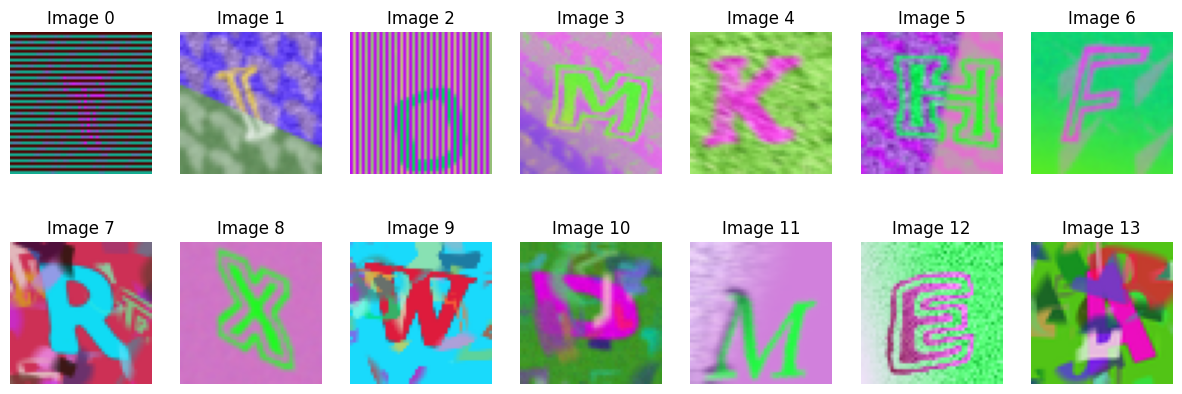

In [136]:
# Вызов функции для визуализации изображений
plot_test_images(images_for_pred, num_images=14)

# <a id="5">Создание модели</a>

А теперь создадим модель нейронной сети с помощью библиотеки torch

## <a id="51">Подготовка данных</a>

Проверим обучающий датасет на пропуски

In [137]:
# Проверка на наличие NaN значений в массиве изображений
if np.isnan(images).any():
    print("В данных есть NaN значения.")
else:
    print("NaN значения отсутствуют.")

NaN значения отсутствуют.


Пропусков нет

## <a id="52">Разделение и трансформация данных</a>

Разделим тренировочную выборку на метки и признаки. Далее обработаем признаки с помощью модуля `transforms`, а также выделим валидационную выборку

In [138]:
# Перестановка осей для соответствия формату PyTorch (N, C, H, W)
images = images.transpose((0, 3, 1, 2))

In [139]:
print(images.shape)

(20000, 3, 48, 48)


In [140]:
# Преобразование данных в тензоры
features = torch.tensor(images, dtype=torch.float32) / 255.0  # Нормализация в [0, 1]
labels = torch.tensor(labels, dtype=torch.long)

In [141]:
# Разделение на тренировочный и валидационный наборы
dataset = TensorDataset(features, labels)
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [142]:
# Определение трансформаций для обучения и валидации
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(112),  # Случайное изменение размера и обрезка
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.RandomRotation(15),  # Случайная ротация на ±15 градусов
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Случайное изменение яркости, контраста, насыщенности и оттенка
    transforms.RandomGrayscale(p=0.2),  # Случайное преобразование в градации серого с вероятностью 20%
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [143]:
# Функция для преобразования данных
def collate_fn(batch, transform):
    images, labels = zip(*batch)
    images = [transforms.ToPILImage()(image) for image in images]  # Преобразование тензоров в PIL Images
    images = torch.stack([transform(image) for image in images])  # Применяем трансформацию
    return images, torch.tensor(labels)

In [144]:
# Формирование тренировочной и валидационной выборок
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: collate_fn(x, transform_train))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: collate_fn(x, transform_val))

## <a id="53">Создание архитектуры модели</a>

Класс `CaptchaEfficientNet` представляет собой нейронную сеть на основе предобученной модели `EfficientNet`, предназначенную для распознавания капч. Модель наследует от nn.Module.

`EfficientNet` — это семейство моделей глубокого обучения, разработанное компанией Google. Эти модели созданы с целью оптимизации как точности, так и эффективности. `EfficientNet` использует принцип масштабирования нейронных сетей для достижения баланса между параметрами сети и вычислительными затратами.
Для этого задания подбирал различные предобученные модели на этом [портале](https://huggingface.co/timm)

In [145]:
# Создание класса модели
class CaptchaEfficientNet(nn.Module):
    def __init__(self, num_classes=26, model_name='efficientnetv2_rw_m.agc_in1k'):
        super(CaptchaEfficientNet, self).__init__()
        # Загрузка предобученной модели
        self.model = timm.create_model(model_name, pretrained=True)
        # Заменяем последний слой на новый с 26 выходами
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [146]:
# Создание экземпляра модели и перемещение на доступное устройство (GPU если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaEfficientNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam (model.parameters(), lr=0.001)

## <a id="54">Обучение модели</a>

Создадим функцию для обучения модели с проверкой на валидационных данных

In [147]:
best_accuracy = 0.0  # Инициализация переменной для хранения лучшей точности
best_model_state = None  # Переменная для сохранения состояния лучшей модели

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    global best_accuracy
    global best_model_state

    # Инициализация списков для хранения значений потерь и точности
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Переключение модели в режим обучения
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)  # Суммирование потерь

        epoch_loss = running_loss / len(train_loader.dataset)  # Среднее значение потерь за эпоху
        train_losses.append(epoch_loss)

        model.eval()  # Переключение модели в режим оценки
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Сохранение модели, если достигнута лучшая точность
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()  # Сохранение состояния модели

    # Построение графика потерь после обучения
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training Loss and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model_state

Запускаем обучение с помощью функции

Epoch 1, Loss: 0.6842, Accuracy: 0.9770
Epoch 2, Loss: 0.6711, Accuracy: 0.9713
Epoch 3, Loss: 0.6908, Accuracy: 0.9753
Epoch 4, Loss: 0.6552, Accuracy: 0.9823
Epoch 5, Loss: 0.6598, Accuracy: 0.9817
Epoch 6, Loss: 0.6515, Accuracy: 0.9850
Epoch 7, Loss: 0.6456, Accuracy: 0.9803
Epoch 8, Loss: 0.6443, Accuracy: 0.9823
Epoch 9, Loss: 0.6550, Accuracy: 0.9817
Epoch 10, Loss: 0.6403, Accuracy: 0.9807
Epoch 11, Loss: 0.6592, Accuracy: 0.9760
Epoch 12, Loss: 0.6483, Accuracy: 0.9800
Epoch 13, Loss: 0.6232, Accuracy: 0.9807
Epoch 14, Loss: 0.6136, Accuracy: 0.9817
Epoch 15, Loss: 0.6105, Accuracy: 0.9797
Epoch 16, Loss: 0.6257, Accuracy: 0.9780
Epoch 17, Loss: 0.6183, Accuracy: 0.9827
Epoch 18, Loss: 0.6176, Accuracy: 0.9847
Epoch 19, Loss: 0.6210, Accuracy: 0.9733
Epoch 20, Loss: 0.6079, Accuracy: 0.9813


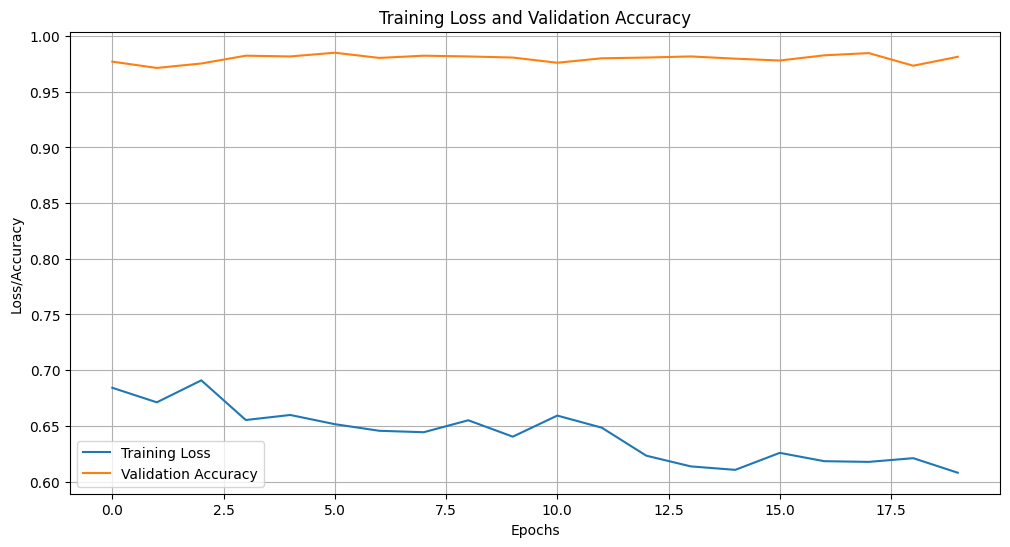

In [166]:
# обучим модель с помощью функции
best_model_state = train_model(20, train_loader, val_loader, model, criterion, optimizer, device)

In [167]:
# посмотрим наилучшую точность
best_accuracy

0.985

In [168]:
# Сохранение состояния модели в файл
torch.save(best_model_state, 'model/best_model_state.pth')

Итого обучил модель на 40 эпохах. Но данные проверял на `best_model_state`

## <a id="55">Проверка модели на тестовых данных</a>

In [152]:
# Загрузка состояния модели из файла
best_model_state = torch.load('model/best_model_state.pth')
model.load_state_dict(best_model_state)

<All keys matched successfully>

Также преобразуем данные в тестовой выборке с помощью `transform`

In [153]:
# Перестановка осей для соответствия формату PyTorch (N, C, H, W)
images_for_pred = images_for_pred.transpose((0, 3, 1, 2))

In [154]:
# Преобразование данных в тензоры и нормализация
features_for_pred = torch.tensor(images_for_pred, dtype=torch.float32) / 255.0  # Нормализация в [0, 1]

In [155]:
# Трансформации для предсказания
transform_pred = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Сделаем обработку тестовых данных по частям (батчам), т.к. не хватает ресурсов, чтобы это сделать разом. Пробовал через DataLoader и ленивую загрузку, но тоже требовало много ресурсов

In [160]:
# Обработка изображений по частям (батчами)
batch_size = 1000  # Размер батча
features_for_pred_transform = []

for i in range(0, len(features_for_pred), batch_size):
    batch = features_for_pred[i:i+batch_size]
    # Преобразование тензоров в PIL Images
    batch_pil = [transforms.ToPILImage()(image) for image in batch]
    # Применение трансформаций
    batch_transformed = torch.stack([transform_pred(image) for image in batch_pil])
    features_for_pred_transform.append(batch_transformed)

In [161]:
# Объединение всех батчей в один тензор
features_for_pred_transform = torch.cat(features_for_pred_transform)

In [162]:
# Создание DataLoader для предсказания
pred_dataset = TensorDataset(features_for_pred_transform)
pred_loader = DataLoader(pred_dataset, batch_size=64, shuffle=False)

Сделаем предсказания на тестовой выборке

In [169]:
model.load_state_dict(best_model_state)

model.eval()  # Перевод модели в режим оценки
predictions = []

with torch.no_grad():  # Отключение вычисления градиентов
    for images in pred_loader:
        images = images[0].to(device)  # Перенос изображений на устройство
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Получение предсказаний
        predictions.extend(predicted.cpu().numpy())  # Сохранение предсказаний

## <a id="56">Сохранение предсказаний на тестовых данных</a>

In [170]:
# Создание DataFrame
results_df = pd.DataFrame({
    'Id': range(len(predictions)),  # Создание списка Id от 0 до количества предсказаний
    'Category': predictions  # Список предсказаний
})

# Просмотр первых нескольких записей DataFrame для проверки
print(results_df.head())

   Id  Category
0   0        19
1   1         8
2   2         3
3   3        12
4   4        10


In [171]:
# Сохранение DataFrame в CSV файл
results_df.to_csv('data/submission.csv', index=False)

# <a id="6">Выводы</a>

По итогу, применив полученные знания, постарался комплексно подойти к решению задачи классификации изображений с использованием сверточных нейронных сетей в PyTorch. Были выполнены этапы от загрузки и первичной обработки данных до моделирования и оценки результатов. Наилучший результат получил с точностью - 0,98325 на описанной выше модели.